# First Practical work

* Name Student 1: Matteo Oliver Bekink
* NIA Student 1: 100575997
* Name Student 2:
* NIA Student 2:
* Name Student 3:
* NIA Student 3:
  
This is second practical work skeleton.

It is divided in 3 parts_

1.   Python module load section: load all the needed modules
2.   Google Drive access and mounting
3.   Host load data






## Module load section
We will install the pycuda module in the colaboratory environment, to combine python and CUDA in our code. Because pycuda is not available by default, this task can take a few minutes.

As well we load numpy and matplotlib modules.

In [1]:
pip install nibabel

Note: you may need to restart the kernel to use updated packages.


We import the Python modules which we will use in the notebook (numpy, pycuda and time module) 

In [4]:
import  numpy  as  np
from sys import getsizeof
import time
from os.path import join

In [5]:
%matplotlib inline
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cProfile

In [6]:
import nibabel as nib

In [28]:
# import your_library here
from multiprocessing.sharedctypes import Value, Array, RawArray
from multiprocessing import Process, Lock
import multiprocessing as mp
import ctypes

# Three-dimensional filtering

The objective of the practice is to implement a three-dimensional filtering of information (usually a 3-dimensional image coming from, for example, medical images) to which a preprocessing must be performed for further analysis.

Due to technical limitations, we will assume that the filtering function is a cube of 3x3 voxels (or three-dimensional pixel) and the image will have a maximum size of 1Gbyte (1024x1024x1024), although it will not necessarily be cubic.

## How to filter a voxel?
To filter a voxel we select the coordinates of the voxel we want to filter and the surrounding neighbors in the 3 dimensions (for a 3x3 filter the coefficient corresponding to the voxel to be filtered corresponds to the positions (1,1,1) of the filter mask).
The n selected neighbors are multiplied by the corresponding coefficients in the filter mask, around the selected voxel, and the products are summed, as in the case of 2-dimensional filters.

The result of this sum is the value assigned to the selected position of the resulting voxel.

## Cases at the edges
To calculate the filtered voxel at a position corresponding to one of the edges of the image, we replicate that layer, so that the data of the missing layer is equal to that of the layer to be filtered.
In the case of edges or corners, the value of the corresponding corner is replicated.

## Clapping
The resulting data will be an floating point 32bits data.

## Mount Google Drive and access grant
This part could be used to access to your Google Drive Data, **ONLY IF YOU ARE USING GOOGLE COLABORATORY**. Otherwise leave commented out. 

For security and privacy reasons, this permission is temporally, and will be requested every time you restart the notebook. 

Your Google Drive will be mounted in the "/content/drive" folder. The first Folder will be "My Drive".

You have to copy your images to a folder in the "My Drive" folder in your Google Drive.

To check your available files, use the cell indicated as "**List Files in Folder**"

In [ ]:
# 
# from google.colab import drive
# drive.mount("/content/drive")

In [ ]:
# !ls /content/drive/My\ Drive/images

## IMAGES DEFINITION

The follow MYDRIVE variable will be used to address where are stored the images files.

Please, change it to your correct location.

All the images should be refered to this directory.

In [7]:
MYDRIVE="./imgs"

We define a variable IMAGE which is constructed joining the "MYDRIVE" varible plus the final path to your image.

In [ ]:
#IMAGE=join(MYDRIVE,HERE YOU HAVE TO WRITE THE IMAGE TO LOAD)

In [8]:
IMAGE=join(MYDRIVE,'someones_epi.nii.gz')

In [9]:
print("Image to load: {0}".format(IMAGE))

Image to load: ./imgs\someones_epi.nii.gz


Loads an image in a numpy variable, and show.

In [10]:
epi_img = nib.load(IMAGE)
epi_img_data = epi_img.get_fdata().astype(np.float32)
epi_img_data.shape

(53, 61, 33)

In [11]:
epi_img_data_final = epi_img_data.T

In [12]:
epi_img_data_final.shape

(33, 61, 53)

In [13]:
epi_img_data.dtype

dtype('float32')

Text(0.5, 0.98, 'Center slices for EPI image')

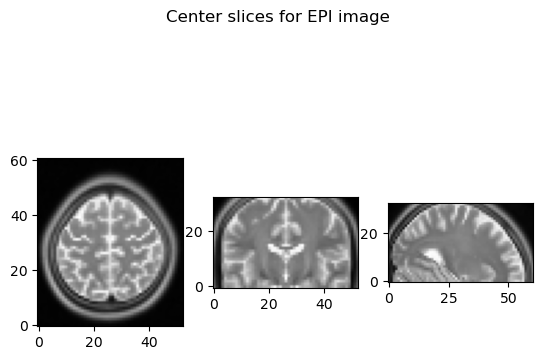

In [14]:
import matplotlib.pyplot as plt

def show_slices(slices):

   """ Function to display row of image slices """

   fig, axes = plt.subplots(1, len(slices))

   for i, slice in enumerate(slices):

       axes[i].imshow(slice, cmap="gray", origin="lower")


slice_0 = epi_img_data_final[26, :, :]
slice_1 = epi_img_data_final[:, 30, :]
slice_2 = epi_img_data_final[:, :, 16]

show_slices([slice_0, slice_1, slice_2])
plt.suptitle("Center slices for EPI image")

## FILTERS DEFINITION

Here we defines our sample filter masks.

In [15]:
#This is an identity filter: the resulting
filter1=np.zeros((3,3,3),dtype=np.float32)
filter1[1,1,1] =1.0

In [16]:
#This is an edge detector filter in xy axis filter: the resulting
filter2=np.zeros((3,3,3),dtype=np.float32)
filter2[0,0,1] = -0.25
filter2[2,0,1] = -0.25
filter2[0,2,1] = 0.25
filter2[2,2,1] = 0.25

In [17]:
#This is an edge detector filter in xz axis: the resulting
filter3=np.zeros((3,3,3),dtype=np.float32)
filter3[0,1,0] = -0.25
filter3[2,1,0] = -0.25
filter3[0,1,2] = 0.25
filter3[2,1,2] = 0.25

# YOUR CODE

## SETUP EXPERIMENT

Recover the image shape, and select the two first items (rows and columns).

In [18]:
image_shape=epi_img_data_final.shape

Allocates the target image memory.

In [27]:
data_size = image_shape[0]*image_shape[1]*image_shape[2]
print(data_size)

 ## HERE YOU MUST DEFINE THE SHARED MEMORY ARRAY WITH THE CORRECT DIMENSION SIZE
filtered_image_shm = Array(ctypes.c_byte,data_size)

106689


### Extra Function we might need

In [ ]:
def to_numpyarray(mp_arr):
    return np.frombuffer(mp_arr.get_obj(), dtype=np.uint8)

def init_sharedarray(shared_array,img_shape):
    global shared_space
    global shared_matrix

    shared_space = shared_array
    shared_matrix = to_numpyarray(shared_space).reshape(img_shape)

def parallel_copy_image_rows(image,row):

        global shared_space
        global shared_matrix
        
        image = image
        # with this instruction we lock the shared memory space, avoiding other parallel processes tries to write on it
        with shared_space.get_lock():
            #while we are in this code block no ones, except this execution thread, can write in the shared memory
            shared_matrix[row,:,:]=image[row,:,:]
        return

In [ ]:
def convolve(row,image,filter):
    # Define the size of the image
    image_shape = image.shape
    (rows,cols,depths)=image_shape

    # Define the size of the filter
    filter_shape = filter.shape
    k_shape = filter_shape[0]//2
    # Assuming the kernel is cubic and has odd dimensions
    # (k_row,k_col,k_depth) = filter_shape

    # We will iterate through each column and then each depth
    # filling the region of interest with values, and then padding
    # them with the same values at the borders
    for c in range(cols):
        for d in range(depths):
            # We define the region of interest, this takes care of not 
            # filling the region out of the image boundaries
            roi = image[max(row-k_shape,0):min(row+k_shape+1,rows),
                        max(c-k_shape,0):min(c+k_shape+1,cols),
                        max(d-k_shape,0):min(d+k_shape+1,depths)]

            # Now we need to fill in the edge cases with padding copy-value padding
            if roi.shape[0] < filter_shape[0]:
                
            if roi.shape[1] < filter_shape[1]:
           
            if roi.shape[2] < filter_shape[2]:

            # We perform the convolution operation (element-wise multiplication and sum)
            conv_value = np.sum(roi * filter)
            # We assign the convolved value to the output image at the center of the filter
            filtered_image_shm[row + filter_shape[0]//2, c + filter_shape[1]//2, d + filter_shape[2]//2] = conv_value




In [39]:
def run_parrallel(sh_data,image,filter,NUMCORES=20):
    image_shape=image.shape

    #Convert the shared data array into a mutable numpy array
    result_matrix=to_numpyarray(sh_data).reshape(image_shape)
    
    #In parralel start to read the global data into shared data by row
    rows=range(image_shape[0])
    with mp.Pool(processes=NUMCORES,initializer=init_sharedarray,initargs=[shared_space,image_shape]) as p:
        p.map(parallel_copy_image_rows,[image,rows])
    
    # Run the parralel Convolution
    with mp.Pool(processes=NUMCORES,initializer=init_sharedarray,initargs=[shared_space,image_shape]) as p:
        p.map(convolve,rows)

    return result_matrix


    

In [38]:
convolve(filtered_image_shm,image_shape)

(33, 61, 53)
(33, 61, 53)


### The next lines is only valid for the filter mask filter1, in order to check if the image was readed correct

In [ ]:
np.allclose(filtered_image,epi_img_data_final)

*NOTE* The follow code fetch from the stack the exectution statistics produced by the magic metacommand %%timeit and stores it in a python variable.

# Show results


In [ ]:
slice_0 = filtered_image[26, :, :]
slice_1 = filtered_image[:, 30, :]
slice_2 = filtered_image[:, :, 16]

show_slices([slice_0, slice_1, slice_2])
plt.suptitle("Center slices for EPI image")

In [ ]:
print("Best execution time: {}".format(statistics.best))
print("Worst execution time: {}".format(statistics.worst))
print("Mean execution time: {mean} ({stdev} std dev)".format(mean=statistics.average,stdev=statistics.stdev))

# CONCLUSIONS

In [ ]:
***